In [16]:
import pandas as pd
import numpy as np

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from IPython.display import display


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher
from scipy.sparse import hstack


In [18]:
user_feature_table = pd.read_csv('user_features.csv')

In [19]:
features_to_use = [
    'numconnections', 'seniority', 'currentindustry', 'mapped_role',
    'total_experience_years', 'highest_degree', 'company_cleaned', 'campus_cleaned'
]

model_data = user_feature_table[features_to_use].copy()
print(f"Select {len(features_to_use)} features for modeling\n")

Select 8 features for modeling



In [20]:
missing_values = model_data.isnull().sum()
print(missing_values)

numconnections              0
seniority                 102
currentindustry           366
mapped_role               102
total_experience_years    420
highest_degree              0
company_cleaned           104
campus_cleaned            236
dtype: int64


In [21]:
print(model_data.shape)
model_data_cleaned = model_data.dropna()
print(model_data_cleaned.shape)

(4755, 8)
(4067, 8)


In [22]:
# 分离数值和类别特征的列名
categorical_features = model_data_cleaned.select_dtypes(include=['object', 'category']).columns
numerical_features = model_data_cleaned.select_dtypes(include=np.number).columns

# 检查并分离高/低基数特征
threshold = 20
cardinality = model_data_cleaned[categorical_features].nunique()
high_cardinality_cols = cardinality[cardinality > threshold].index.tolist()
low_cardinality_cols = cardinality[cardinality <= threshold].index.tolist()

print(f"numerical_features: {numerical_features.tolist()}")
print(f"Low base category features (to be one-hot encoded): {low_cardinality_cols}")
print(f"High base category feature (will perform feature hashing): {high_cardinality_cols}\n")

numerical_features: ['numconnections', 'seniority', 'total_experience_years']
Low base category features (to be one-hot encoded): ['highest_degree']
High base category feature (will perform feature hashing): ['currentindustry', 'mapped_role', 'company_cleaned', 'campus_cleaned']



In [23]:
# --- 对数值特征进行标准化 ---
print("Processing numerical features...")
scaler = StandardScaler()
scaled_numericals = scaler.fit_transform(model_data_cleaned[numerical_features])

# --- 对低基数特征进行独热编码 ---
print("Processing low base category features...")
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
encoded_low_cardinality_sparse = ohe.fit_transform(model_data_cleaned[low_cardinality_cols])

# --- 对高基数特征进行特征哈希 ---
print("Processing high-cardinality category features...")
n_hash_features = 50 # 设定哈希后的维度为50
hasher = FeatureHasher(n_features=n_hash_features, input_type='dict')
high_card_data_dict = model_data_cleaned[high_cardinality_cols].to_dict('records')
hashed_high_cardinality = hasher.fit_transform(high_card_data_dict)

Processing numerical features...
Processing low base category features...
Processing high-cardinality category features...


In [24]:
# 合并所有处理好的特征矩阵
final_features_sparse = hstack([
    scaled_numericals,
    encoded_low_cardinality_sparse,
    hashed_high_cardinality
])

print("Preprocessing completed！")
print(f"The shape of the sparse feature matrix used for modeling: {final_features_sparse.shape}")

Preprocessing completed！
The shape of the sparse feature matrix used for modeling: (4067, 60)


In [25]:
# --- UMAP 降维 ---
# UMAP可以直接处理稀疏矩阵
reducer = umap.UMAP(n_components=10, random_state=42)
embedding = reducer.fit_transform(final_features_sparse)
print(f"UMAP dimensionality reduction completed. Shape after dimensionality reduction.: {embedding.shape}\n")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP dimensionality reduction completed. Shape after dimensionality reduction.: (4067, 10)



--- Use the silhouette coefficient to find the optimal number of clusters (k). ---
Calculating the contour coefficient for different k values....
  k=4, silhouette coefficient: 0.4533
  k=5, silhouette coefficient: 0.4466
  k=6, silhouette coefficient: 0.4013
  k=7, silhouette coefficient: 0.4239
  k=8, silhouette coefficient: 0.4189
  k=9, silhouette coefficient: 0.4093
  k=10, silhouette coefficient: 0.4232
  k=11, silhouette coefficient: 0.4262
  k=12, silhouette coefficient: 0.4179


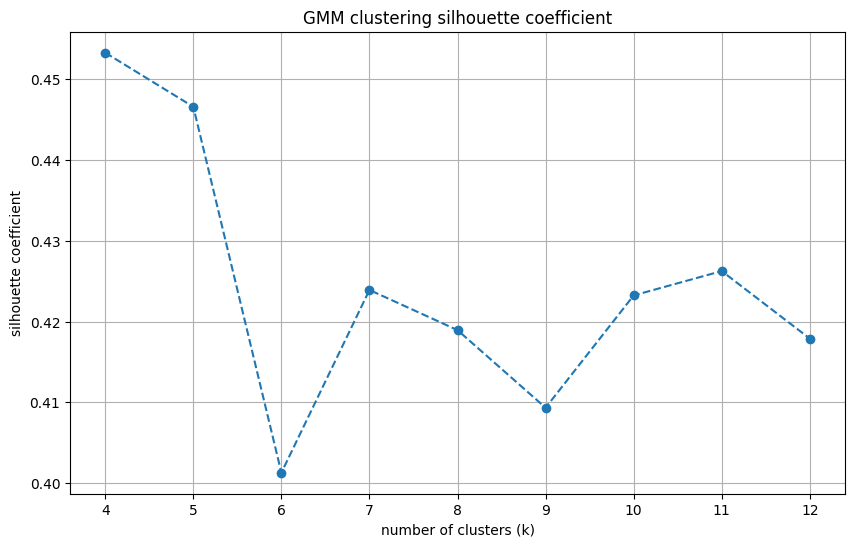


Based on the silhouette coefficient, the optimal number of clusters k = 4



In [26]:
# --- GMM聚类与模型筛选 ---
print("--- Use the silhouette coefficient to find the optimal number of clusters (k). ---")
k_values = range(4, 13)
silhouette_scores = []

print("Calculating the contour coefficient for different k values....")
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(embedding)
    score = silhouette_score(embedding, labels)
    silhouette_scores.append(score)
    print(f"  k={k}, silhouette coefficient: {score:.4f}")

# 绘制图表来帮助选择k值
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('GMM clustering silhouette coefficient')
plt.xlabel('number of clusters (k)')
plt.ylabel('silhouette coefficient')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(silhouette_scores)]
print(f"\nBased on the silhouette coefficient, the optimal number of clusters k = {best_k}\n")

--- Use k=4 to execute final clustering and visualize ---
Add 'cluster_id' to model_data_cleaned。


/tmp/ipython-input-4012695185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_cleaned.loc[:, 'cluster_id'] = cluster_labels
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


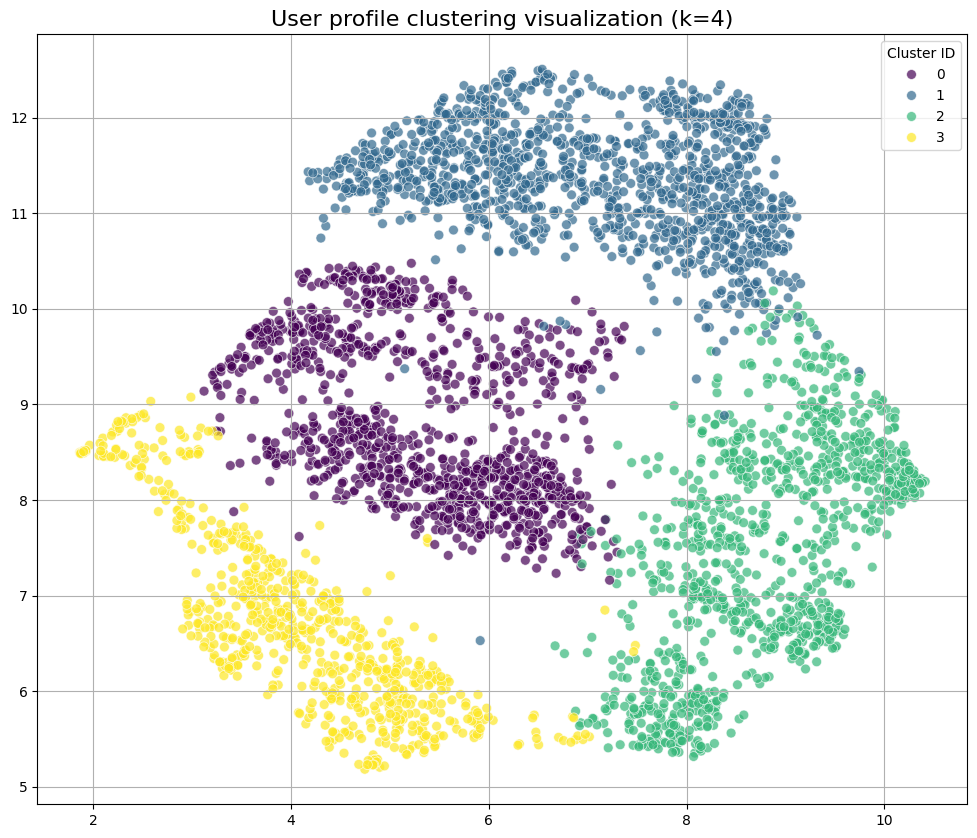


--- finished！---


,cluster_id
0,1
1,1
2,2
3,2
4,2


In [27]:
# --- Final clustering and visualize ---
print(f"--- Use k={best_k} to execute final clustering and visualize ---")
final_gmm = GaussianMixture(n_components=best_k, random_state=42)
cluster_labels = final_gmm.fit_predict(embedding)

model_data_cleaned.loc[:, 'cluster_id'] = cluster_labels
print("Add 'cluster_id' to model_data_cleaned。")

reducer_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer_2d.fit_transform(final_features_sparse)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=cluster_labels,
    palette='viridis',
    s=50,
    alpha=0.7
)
plt.title(f'User profile clustering visualization (k={best_k})', fontsize=16)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

print("\n--- finished！---")
display(model_data_cleaned[['cluster_id']].head())

In [29]:
# --- 下载完整的、带有簇标签的数据集 ---

full_dataset_filename = 'clustered_user_data.csv'

# index=False 避免将Pandas的行索引写入文件
model_data_cleaned.to_csv(full_dataset_filename, index=False)

print(f"\n✅ The file '{full_dataset_filename}' has been successfully saved to the current directory of Colab.")
print("You can now see it in the 'Files' panel on the left, and right-click to download.")


✅ The file 'clustered_user_data.csv' has been successfully saved to the current directory of Colab.
You can now see it in the 'Files' panel on the left, and right-click to download.


In [30]:
# --- 分开下载每一个簇的数据集 ---

# 1. 获取所有唯一的簇ID
unique_clusters = model_data_cleaned['cluster_id'].unique()
# 对簇ID进行排序，确保下载的文件名是有序的
unique_clusters.sort()

print(f"Dicovered {len(unique_clusters)} independent clusters: {unique_clusters}")

# 2. 循环遍历每一个簇ID
for cluster_id in unique_clusters:
    # 筛选出当前簇的所有数据
    cluster_df = model_data_cleaned[model_data_cleaned['cluster_id'] == cluster_id]

    # 为当前簇的数据集定义文件名
    cluster_filename = f'cluster_{cluster_id}_users.csv'

    print(f"\n  - Creating file: '{cluster_filename}'...")
    print(f"    This cluster includes {len(cluster_df)} User record")

    # 将当前簇的DataFrame保存为CSV文件
    cluster_df.to_csv(cluster_filename, index=False)

print("\n--- All files have been saved. ---")

Dicovered 4 independent clusters: [0 1 2 3]

  - Creating file: 'cluster_0_users.csv'...
    This cluster includes 1072 User record

  - Creating file: 'cluster_1_users.csv'...
    This cluster includes 1251 User record

  - Creating file: 'cluster_2_users.csv'...
    This cluster includes 1027 User record

  - Creating file: 'cluster_3_users.csv'...
    This cluster includes 717 User record

--- All files have been saved. ---
